In [66]:
from numpy import *
from time import sleep
import os
import errno
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D
import pickle
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers import Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.initializers import glorot_normal
from keras.utils import np_utils
#from keras_sequential_ascii import sequential_model_to_ascii_printout
from sklearn.model_selection import train_test_split

In [67]:
import tensorflow as tf

In [68]:
cd /Users/sagarsahoo/Downloads/

/Users/sagarsahoo/Downloads


In [69]:
def silent_remove(filename):
    try:
        os.remove(filename)
    except OSError as e:  # this would be "except OSError, e:" before Python 2.6
        if e.errno != errno.ENOENT:  # errno.ENOENT = no such file or directory
            raise  # re-raise exception if a different error occurred



def unpickle(file):
    with open(file, 'rb') as fo:
        d = pickle.load(fo, encoding='bytes')
    return d


def read_data(folder):
    x_data_temp = []
    y_data_temp = []
    x_test_data_temp = []
    y_test_data_temp = []
    # We don't use numpy's vstack here as that would be wasteful, because every time you do a vstack, numpy would end
    # up copying the whole array to a new location. Hence we use a little trick to first store the data in a list and
    # then convert it to an numpy array

    for file in os.listdir(folder):
        if file.endswith(".meta") or file.endswith(".html"):
            print("Ignoring html and meta files")
        elif "test_batch" in file:
            # test data file detected. we are gonna load it separately
            test_data_temp = unpickle(folder + "/" + file)
            x_test_data_temp.append(test_data_temp[b'data'])
            y_test_data_temp.append(test_data_temp[b'labels'])
        else:
            temp_data = unpickle(folder + "/" + file)
            x_data_temp.append(temp_data[b'data'])
            y_data_temp.append(temp_data[b'labels'])
    x_data = array(x_data_temp)
    y_data = array(y_data_temp)
    x_test_data = array(x_test_data_temp)
    y_test_data = array(y_test_data_temp)
    return [x_data, y_data, x_test_data, y_test_data]

In [70]:
X_train_temp, y_train_temp, X_test_temp, y_test_temp = read_data("cifar-10-batches-py")

Ignoring html and meta files
Ignoring html and meta files


In [71]:
print(X_train_temp.shape, X_train_temp.ndim, type(X_train_temp))
print(y_train_temp.shape, y_train_temp.ndim, type(y_train_temp))

(5, 10000, 3072) 3 <class 'numpy.ndarray'>
(5, 10000) 2 <class 'numpy.ndarray'>


In [72]:
X_train_temp = X_train_temp.reshape(X_train_temp.shape[0] * X_train_temp.shape[1], X_train_temp.shape[2])
y_train_temp = y_train_temp.reshape(y_train_temp.shape[0] * y_train_temp.shape[1])

# Similarly for X_test_temp and y_test_data

X_test_temp = X_test_temp.reshape(X_test_temp.shape[0] * X_test_temp.shape[1], X_test_temp.shape[2])
y_test_temp = y_test_temp.reshape(y_test_temp.shape[0] * y_test_temp.shape[1])

print(X_train_temp.shape, X_train_temp.ndim, type(X_train_temp))
print(y_train_temp.shape, y_train_temp.ndim, type(y_train_temp))

print(X_test_temp.shape, X_test_temp.ndim, type(X_test_temp))
print(y_test_temp.shape, y_test_temp.ndim, type(y_test_temp))


(50000, 3072) 2 <class 'numpy.ndarray'>
(50000,) 1 <class 'numpy.ndarray'>
(10000, 3072) 2 <class 'numpy.ndarray'>
(10000,) 1 <class 'numpy.ndarray'>


In [73]:
X_train, y_train = shuffle(X_train_temp, y_train_temp, random_state=4)
X_test, y_test = shuffle(X_test_temp, y_test_temp, random_state=4)

In [74]:
# Splitting X and y in training and val data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=13433382)

# Neural Networks

In [75]:
# Keras Parameters
batch_size = 32
nb_classes = 10
nb_epoch = 20
img_rows, img_col = 32, 32
img_channels = 3
nb_filters = 32
nb_pool = 2
nb_conv = 3

# Now that our data has been shuffled and spitted,  lets reshape it and get it ready to be fed into our CCN model

X_train = X_train.reshape(X_train.shape[0], 3, 32, 32)
y_train = np_utils.to_categorical(y_train, nb_classes)

X_val = X_val.reshape(X_val.shape[0], 3, 32, 32)
y_val = np_utils.to_categorical(y_val, nb_classes)

X_test = X_test.reshape(X_test.shape[0], 3, 32, 32)
y_test = np_utils.to_categorical(y_test, nb_classes)

# Finally print shape of this data :

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

# Regularize the data
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_val /= 255
X_test /= 255

(40000, 3, 32, 32) (40000, 10)
(10000, 3, 32, 32) (10000, 10)
(10000, 3, 32, 32) (10000, 10)


In [76]:
import keras.backend.tensorflow_backend as tfback

In [77]:
def _get_available_gpus():  

    if tfback._LOCAL_DEVICES is None:  
        devices = tf.config.list_logical_devices()  
        tfback._LOCAL_DEVICES = [x.name for x in devices]  
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]


tfback._get_available_gpus = _get_available_gpus

In [78]:

# Starting with Keras now

model = Sequential()

model.add(Conv2D(nb_filters, (nb_conv, nb_conv),
                 padding='valid',
                 activation='relu',
                 input_shape=(img_channels, img_rows, img_col),
                 data_format='channels_first',))

model.add(Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool) ,dim_ordering='tf'))
model.add(Dropout(0.2))

model.add(Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool),dim_ordering='tf'))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(nb_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch,
                    verbose=1, validation_data=(X_val, y_val))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_last")`
  if sys.path[0] == '':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_last")`
  app.launch_new_instance()


Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 114s 3ms/step - loss: 1.6619 - accuracy: 0.3978 - val_loss: 1.3637 - val_accuracy: 0.5122
Epoch 2/20
40000/40000 [==============================] - 152s 4ms/step - loss: 1.3469 - accuracy: 0.5204 - val_loss: 1.2103 - val_accuracy: 0.5749
Epoch 3/20
40000/40000 [==============================] - 111s 3ms/step - loss: 1.2322 - accuracy: 0.5617 - val_loss: 1.1269 - val_accuracy: 0.5980
Epoch 4/20
40000/40000 [==============================] - 111s 3ms/step - loss: 1.1566 - accuracy: 0.5874 - val_loss: 1.0682 - val_accuracy: 0.6237
Epoch 5/20
40000/40000 [==============================] - 115s 3ms/step - loss: 1.1053 - accuracy: 0.6072 - val_loss: 1.0218 - val_accuracy: 0.6417
Epoch 6/20
40000/40000 [==============================] - 113s 3ms/step - loss: 1.0628 - accuracy: 0.6241 - val_loss: 0.9943 - val_accuracy: 0.6450
Epoch 7/20
40000/40000 [==============================] - 117s

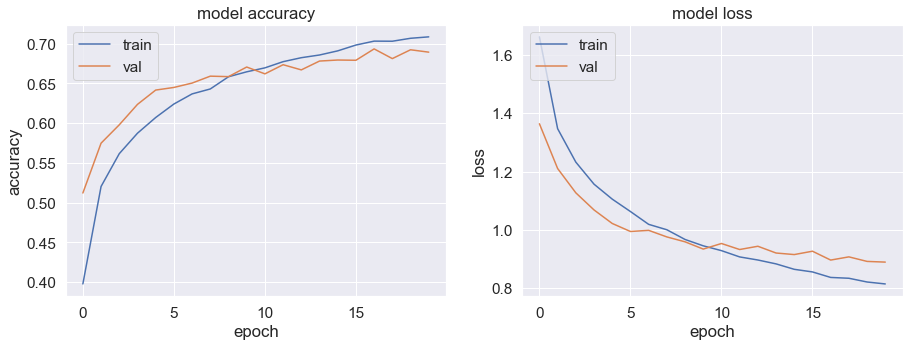

In [79]:
f = plt.figure(figsize=(15,5))


ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

# summarize history for accuracy
ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])
ax.set_title('model accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='upper left')
# summarize history for loss
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')


In [80]:

# Test this trained model on our test data
score = model.evaluate(X_test, y_test, verbose=0)
print("Test Score :", score[0])
print("Test accuracy: ", score[1])
#print(model.predict_classes(X_test[1:50]))
#print(y_test[1:50])

Test Score : 0.8776295792579651
Test accuracy:  0.696399986743927


In [81]:
print("First deleting old models if they exists !!")
silent_remove("model.json")
silent_remove("model.h5")
silent_remove("whole_model.h5")

sleep(2)

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
model.save("whole_model.h5")
print("Saved model to disk")

First deleting old models if they exists !!
Saved model to disk


<b>Prediction on the Test Set

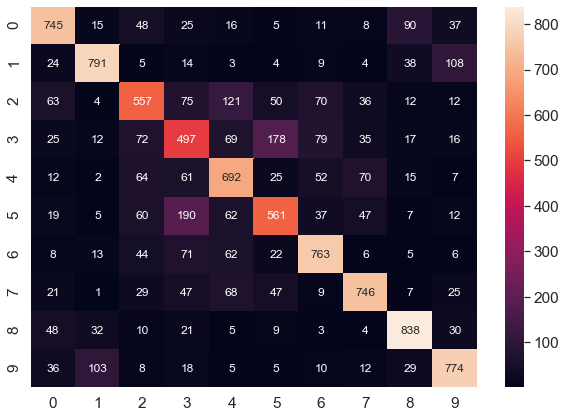

In [82]:

from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict(X_test, verbose=2)
y_pred = np.argmax(Y_pred, axis=1)

#for ix in range(10):
#    print(ix, confusion_matrix(np.argmax(y_test,axis=1),y_pred)[ix].sum())
cm = confusion_matrix(np.argmax(y_test,axis=1),y_pred)
#print(cm)

# Visualizing of confusion matrix
import seaborn as sn
import pandas  as pd


df_cm = pd.DataFrame(cm, range(10),range(10))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12},fmt="d")# font size
plt.show()

# VGG-16

In [52]:
import multiprocessing as mp

In [64]:
core_num = mp.cpu_count()

print(core_num)

config = tf.compat.v1.ConfigProto(
    inter_op_parallelism_threads=core_num,
    intra_op_parallelism_threads=core_num)

#sess = tf.Session(config=config)

# Loading the CIFAR-10 dataset

from keras.datasets import cifar10

# Declare variables

BATCH_NORM = False

batch_size = 64
num_classes = 10
epochs = 2
data_augmentation = True

(x_train, y_train), (x_test, y_test) = cifar10.load_data() # x_train - training data(images), y_train - labels(digits)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']



# Convert and pre-processing

y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train  /= 255
x_test /= 255


X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=13433382)

4
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [65]:

# Define Model
def vgg_base_model():
    model = Sequential()

    model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:], name='block1_conv1'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(64, (3, 3), padding='same', name='block1_conv2'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))

    model.add(Conv2D(128, (3, 3), padding='same', name='block2_conv1'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(128, (3, 3), padding='same', name='block2_conv2'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))

    model.add(Conv2D(256, (3, 3), padding='same', name='block3_conv1'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(256, (3, 3), padding='same', name='block3_conv2'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(256, (3, 3), padding='same', name='block3_conv3'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(256, (3, 3), padding='same', name='block3_conv4'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))

    model.add(Conv2D(512, (3, 3), padding='same', name='block4_conv1'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(512, (3, 3), padding='same', name='block4_conv2'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(512, (3, 3), padding='same', name='block4_conv3'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(512, (3, 3), padding='same', name='block4_conv4'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))

    model.add(Conv2D(512, (3, 3), padding='same', name='block5_conv1'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(512, (3, 3), padding='same', name='block5_conv2'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(512, (3, 3), padding='same', name='block5_conv3'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(512, (3, 3), padding='same', name='block5_conv4'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Flatten())

    model.add(Dense(4096))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(4096, name='fc2'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('softmax'))

    sgd = SGD(lr=0.0005, decay=0, nesterov=True)

    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

cnn_n = vgg_base_model()
cnn_n.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_39 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_40 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
activation_41 (Activation)   (None, 16, 16, 128)     

In [63]:
cnn = cnn_n.fit(x_train, y_train, batch_size=batch_size, 
                epochs=epochs, 
                    validation_data=(X_val, y_val), shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/2
20544/50000 [===========>..................] - ETA: 48:21 - loss: 2.3026 - accuracy: 0.1028

KeyboardInterrupt: 

In [ ]:
# Vizualizing model structure
sequential_model_to_ascii_printout(cnn_n)